In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from helper_functions import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier

# Credit Card Fraud Detection  

## About Data  

It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase. The dataset contains transactions made by credit cards in September 2013 by European cardholders.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

source: https://www.kaggle.com/mlg-ulb/creditcardfraud


In [2]:
# Load data
fraud_data = pd.read_csv('creditcard.csv')
print(fraud_data.head())


   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

## Data Distribution

We have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions. 

In [3]:
# Inspect data
fraude_number = len(fraud_data[fraud_data.Class == 1])
print("Število vseh primerov: " + repr(len(fraud_data)))
print("Število zlorab: " + repr(fraude_number))
print("Število nezlorab: " + repr(len(fraud_data) - fraude_number))


Število vseh primerov: 284807
Število zlorab: 492
Število nezlorab: 284315


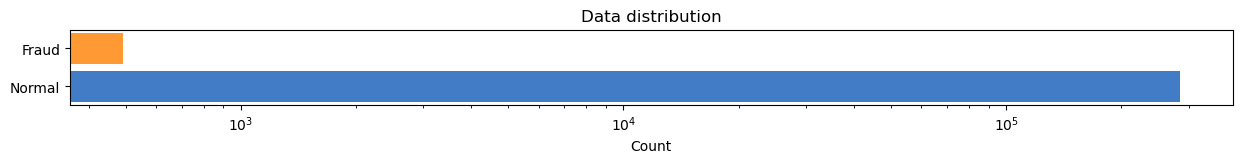

In [4]:
counts = fraud_data['Class'].value_counts()
plt.figure(figsize=(15, 1), dpi=100)
plt.barh(["Normal", "Fraud"], counts, log=True, color =['#427CC7', '#FF9933'])
plt.xlabel("Count")
plt.title("Data distribution")
plt.show()


### Amount-Time Distribution

From the graph below we notice that Time does not separate normal from fraudulent transactions. Furthermore we notice that majority of fraudulent transactions are low Amunts. Therefore we can drop Time and scale Amount column.

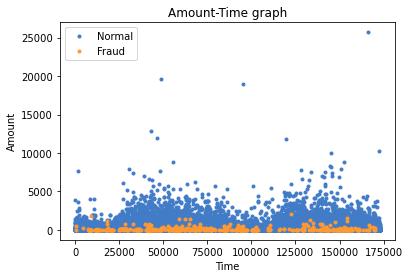

In [5]:
data_f = fraud_data[fraud_data['Class'] == 1] 
data_n = fraud_data[fraud_data['Class'] == 0] 
plt.plot(data_n['Time'], data_n['Amount'], '.', color='#427CC7', label="Normal") 
plt.plot(data_f['Time'], data_f['Amount'], '.', color='#FF9933', label="Fraud") 
plt.legend()
plt.title('Amount-Time graph')
plt.xlabel('Time')
plt.ylabel('Amount')
plt.show()

In [6]:
# Scale Amount
column_amount = fraud_data.Amount.values
fraud_data.Amount = RobustScaler().fit_transform(column_amount.reshape(-1,1))

In [7]:
# Delete Time 
fraud_data.drop('Time', axis=1, inplace=True)

In [8]:
# Delete duplicates
fraud_data.drop_duplicates(inplace=True)
print("Število vseh primerov: " + repr(len(fraud_data)))
print("Število zlorab: " + repr(fraude_number))
print("Število nezlorab: " + repr(len(fraud_data) - fraude_number))

Število vseh primerov: 275663
Število zlorab: 492
Število nezlorab: 275171


## What is imbalanced classification?  

Classification predictive modeling involves predicting a class label for a given observation.

An imbalanced classification problem is an example of a classification problem where the distribution of examples across the known classes is biased or skewed. The distribution can vary from a slight bias to a severe imbalance where there is one example in the minority class for hundreds, thousands, or millions of examples in the majority class or classes.

Imbalanced classifications pose a challenge for predictive modeling as most of the machine learning algorithms used for classification were designed around the assumption of an equal number of examples for each class. This results in models that have poor predictive performance, specifically for the minority class. This is a problem because typically, the minority class is more important and therefore the problem is more sensitive to classification errors for the minority class than the majority class.

source: https://machinelearningmastery.com/what-is-imbalanced-classification/

## Resampling

One approach to addressing the problem of class imbalance is to randomly resample the training dataset. The two main approaches to randomly resampling an imbalanced dataset are to delete examples from the majority class, called undersampling, and to duplicate examples from the minority class, called oversampling.

source: https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/

In [9]:
# Divide to classification data and other attributes

# Classification data Y
Y = fraud_data['Class'].values

# Other attributes data X
data_features = list(fraud_data.columns)
data_features.remove('Class')
X = fraud_data[data_features].values

#podatke razdelimo na učno in testno množico 0.7%, 0.3% (jih premeša in poskrbi da se Y in X enako zmeasat in jih pravilno deli )
#X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.3, random_state=1)

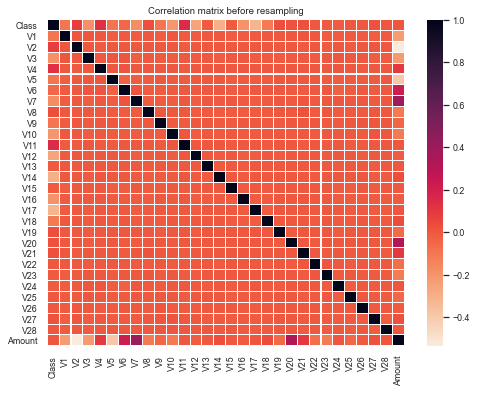

In [10]:
# Heatmap before resampling
import seaborn as sns

df = pd.DataFrame(X, columns =list(fraud_data.columns[:-1]))
df.insert(0, "Class", Y, True)

corr = df.corr()
plt.figure(figsize = (8,6))
sns.set(font_scale=0.8)
sns.heatmap(corr, cmap="rocket_r",linewidths=.05)
plt.title("Correlation matrix before resampling")
plt.show()


In [11]:
# Evaluation before resampling with custom cross_validation, K-fold with k=3, more than k=3 takes to much time
classifier_dict= {  "Logistic Regression":LogisticRegression(random_state = 1, max_iter = 1000), 
                    "Random Forest": RandomForestClassifier(random_state = 1),
                    "XGBoost": XGBClassifier(max_depth = 4, use_label_encoder=False),
                    "KNeighbors": KNeighborsClassifier(n_neighbors=3)}

data_features = list(fraud_data.columns)
data_features.remove('Class')

cross_validate(classifier_dict, X,Y, 3, resample="normal")

Logistic Regression
Preceision score:  0.8574878588752063
Recall score:  0.6027683883689289
Accuracy:  0.9991438821118553
F1 score:  0.7076923633103408

Random Forest
Preceision score:  0.9414396574018312
Recall score:  0.7781247582434668
Accuracy:  0.9995356649505079
F1 score:  0.852021811219413

[13:00:57] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:01:09] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:01:21] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set 

### Undersampling

This method works with the majority class. It reduces the number of observations from the majority class to make the data set balanced.   
When there exists a class that is in abundance, undersampling aims to reduce the size of the abundant class to balance the dataset. It uses all of the rare events but reduces the number of abundant events to create two equally sized classes.   
This method is best to use when the data set is huge and reducing the number of training samples helps to improve run time and storage troubles.   
Here you take the majority class and try to create new samples that match the length of the minority samples.   

![](undersampling.png)  
source: https://www.ml-concepts.com/2021/10/08/2-undersampling-techniques/

#### Random Undersampling
- Randomly delete examples in the majority class.
- under-sampling shrinks the data size, less time is necessary for learning.
The disadvantage is that discarding majority examples may lead to losing useful information of the majority class.

In [12]:
from imblearn.under_sampling import RandomUnderSampler
# Resample data
rus = RandomUnderSampler(random_state = 0)
X_rus, Y_rus = rus.fit_resample(X, Y)

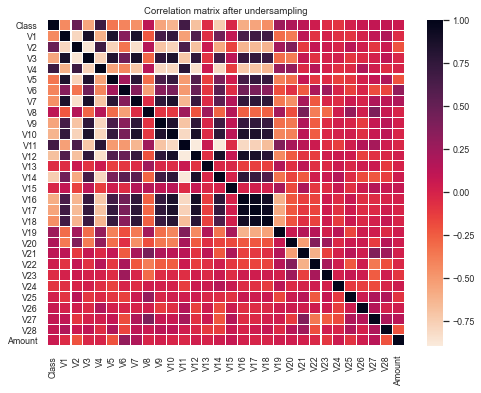

In [13]:
# Heatmap after undersampling
df = pd.DataFrame(X_rus, columns =list(fraud_data.columns[:-1]))
df.insert(0, "Class", Y_rus, True)

corr = df.corr()
plt.figure(figsize = (8,6))
sns.set(font_scale=0.8)
sns.heatmap(corr, cmap="rocket_r",linewidths=.05)
plt.title("Correlation matrix after undersampling")
plt.show()

In [14]:
# Evaluation after undersampling with cross_validation, K-fold, k=3
cross_validate(classifier_dict, X,Y, 3, resample="rus")

Logistic Regression
Preceision score:  0.04592207115495669
Recall score:  0.9018314376353277
Accuracy:  0.9664373153193662
F1 score:  0.08726528953808721

Random Forest
Preceision score:  0.06609557287763863
Recall score:  0.888621507443749
Accuracy:  0.9778461407718834
F1 score:  0.12289227163547378

[13:16:36] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:16:37] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:16:37] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly 

### Oversampling

Oversampling can be defined as adding more copies of the minority class to obtain a balanced dataset. Oversampling can be a good choice when you don’t have a ton of data to work with. It is appropriate when data scientists do not have enough information. One class is abundant, or the majority and the other is rare, or the minority.  This technique attempts to increment the size of rare samples to create a balance when the data is insufficient.

![](oversampling.png)  
source: https://www.ml-concepts.com/2021/10/08/1-oversampling-techniques/

#### Random Oversampling

- Randomly duplicate examples in the minority class.
- However, it can discard useful data and it may cause overfitting because learning algorithms tend to focus on replicated minority examples. 
- This technique can be effective for those machine learning algorithms that are affected by a skewed distribution and where multiple duplicate examples for a given class can influence the fit of the model.

In [15]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=2)
X_ros, Y_ros = ros.fit_resample(X, Y)

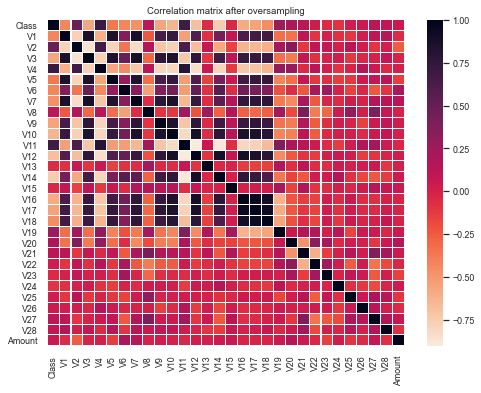

In [16]:
# Heatmap after oversampling
df = pd.DataFrame(X_ros, columns =list(fraud_data.columns[:-1]))
df.insert(0, "Class", Y_ros, True)

corr = df.corr()
plt.figure(figsize = (8,6))
sns.set(font_scale=0.8)
sns.heatmap(corr, cmap="rocket_r",linewidths=.05)
plt.title("Correlation matrix after oversampling")
plt.show()

In [17]:
# Evaluation after oversampling with cross_validation, K-fold, k=3
cross_validate(classifier_dict, X,Y, 3, resample="ros")

Logistic Regression
Preceision score:  0.060330969149986834
Recall score:  0.9054077358955408
Accuracy:  0.9756006491693435
F1 score:  0.11307337451569684

Random Forest
Preceision score:  0.9416840469472048
Recall score:  0.7694115956311078
Accuracy:  0.9995211540188009
F1 score:  0.8464122232365265

[13:26:38] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:26:59] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:27:21] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly 

#### SMOTE

- SMOTE (Synthetic Minority Oversampling Technique) is one of the most commonly used oversampling methods to solve the imbalance problem.
- It aims to balance class distribution by randomly increasing minority class examples by replicating them.
- SMOTE synthesizes new minority instances between existing minority instances. It generates the virtual training records by linear interpolation for the minority class. 
- The general idea of SMOTE is the generation of synthetic data between each sample of the minority class and its “k” nearest neighbors. That is, for each one of the samples of the minority class, its “k” nearest neighbors are located (by default k = 5), then between the pairs of points generated by the sample and each of its neighbors, a new synthetic data is generated. 

In [18]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=2)
X_sm, Y_sm = sm.fit_resample(X, Y)

In [19]:
# Evaluation after oversampling with cross_validation, K-fold, k=3
cross_validate(classifier_dict, X,Y, 3, resample="smote")

Logistic Regression
Preceision score:  0.05724120540616112
Recall score:  0.8919989367357788
Accuracy:  0.9742838011753948
F1 score:  0.10749277585038859

Random Forest
Preceision score:  0.8702650261656172
Recall score:  0.7995174416227048
Accuracy:  0.9994486021632724
F1 score:  0.8325330893816781

[14:11:55] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:12:27] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:12:59] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly s

## Class Weights

Most machine learning algorithms are not very useful with biased class data. But, we can modify the current training algorithm to take into account the skewed distribution of the classes. This can be achieved by giving different weights to both the majority and minority classes. The difference in weights will influence the classification of the classes during the training phase. The whole purpose is to penalize the misclassification made by the minority class by setting a higher class weight and at the same time reducing weight for the majority class.

source: https://www.analyticsvidhya.com/blog/2020/10/improve-class-imbalance-class-weights/

In [20]:
weights={0: 1, 1: 325}
classifier_dict_weights = { "Logistic Regression":LogisticRegression(random_state = 1, max_iter = 1000, class_weight=weights), 
                            "Random Forest": RandomForestClassifier(random_state = 1, class_weight=weights),
                            "XGBoost": XGBClassifier(scale_pos_weight=325, max_depth = 4, use_label_encoder=False)}

cross_validate(classifier_dict_weights, X,Y, 3, resample="normal")

Logistic Regression
Preceision score:  0.10230575473587789
Recall score:  0.8925517782382183
Accuracy:  0.9863855505909385
F1 score:  0.18356473817611998

Random Forest
Preceision score:  0.9440003483106931
Recall score:  0.733684802905891
Accuracy:  0.999466740344289
F1 score:  0.8253930012319275

[14:44:20] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:44:34] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:44:48] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set

## Anomaly Detection

#### Data Preparation

In [21]:
import pandas as pd
import numpy as np
data = pd.read_csv('creditcard.csv')

data = data.drop(['Time'] , axis=1)

In [22]:
# Divide data to frodulent and normal
fraudulent = data.loc[data['Class']==1]

normal = data.loc[ data['Class']==0]

In [23]:
# Drop Class
fraudulent = fraudulent .drop(['Class'] , axis=1)

normal = normal.drop(['Class'] , axis=1)

In [24]:
from sklearn.model_selection import train_test_split
normal_train_set, normal_test_set= train_test_split(normal, test_size=0.5, random_state=42)

fraud_test_set = np.array(fraudulent)

#### Algorithm Evaluation

In [25]:
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor
from helper_functions import validate_anomaly

classifier_dict_anomaly= {  "Isolarion Forest":IsolationForest(max_samples=100), 
                            "Elliptic Envelope": EllipticEnvelope(random_state=1, support_fraction = 75000),
                            "Local Outlier Factor": LocalOutlierFactor(n_neighbors=2, novelty=True)}

validate_anomaly(normal_train_set, normal_test_set, fraud_test_set, classifier_dict_anomaly)

Isolarion Forest
Preceision score:  0.03946621237932993
Recall score : 0.8475609756097561
Accuracy:  0.9283280757097792
F1 score:  0.07542051003798156

Elliptic Envelope
Preceision score:  0.029464285714285714
Recall score : 0.8719512195121951
Accuracy:  0.9004977216964599
F1 score:  0.05700239170874302

Local Outlier Factor
Preceision score:  0.015539927404718693
Recall score : 0.556910569105691
Accuracy:  0.8767893445495969
F1 score:  0.03023615096005297

